In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import scale
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve
from sklearn.svm import SVC
import seaborn as sns
sns.set(style="white")
import time
import sys
reload(sys)
sys.setdefaultencoding("utf-8")

In [2]:
f_cat = ['VOIE_DEPOT','COUNTRY','SOURCE_BEGIN_MONTH','FISRT_APP_COUNTRY','FISRT_APP_TYPE','LANGUAGE_OF_FILLING',
        'FIRST_CLASSE','TECHNOLOGIE_SECTOR','TECHNOLOGIE_FIELD','MAIN_IPC','FISRT_INV_COUNTRY','FISRT_INV_TYPE','SOURCE_CITED_AGE',
        'SOURCE_IDX_ORI','SOURCE_IDX_RAD']

f_con = ['APP_NB','APP_NB_PAYS','APP_NB_TYPE','NB_CLASSES','NB_ROOT_CLASSES','NB_SECTORS','NB_FIELDS','INV_NB',
        'INV_NB_PAYS','INV_NB_TYPE','cited_n','cited_nmiss','cited_age_min','cited_age_median','cited_age_max','cited_age_mean',
        'cited_age_std','NB_BACKWARD_NPL','NB_BACKWARD_XY','NB_BACKWARD_I','NB_BACKWARD_AUTRE','NB_BACKWARD_PL',
        'NB_BACKWARD','pct_NB_IPC','pct_NB_IPC_LY','oecd_NB_ROOT_CLASSES','oecd_NB_BACKWARD_PL','oecd_NB_BACKWARD_NPL',
        'IDX_ORIGIN','IDX_RADIC','PRIORITY_MONTH','FILING_MONTH','PUBLICATION_MONTH','BEGIN_MONTH']

train_fname_cat = 'data/train_cat_1.csv'
test_fname_cat = 'data/test_cat_1.csv'
df_cat = pd.read_csv(train_fname_cat, sep=';')
df_test_cat = pd.read_csv(test_fname_cat, sep=';')
train_fname_con = 'data/train_con_1.csv'
test_fname_con = 'data/test_con_1.csv'
df_con = pd.read_csv(train_fname_con, sep=';')
df_test_con = pd.read_csv(test_fname_con, sep=';')
y_fname = 'data/y_train_1.csv'
df_y = pd.read_csv(y_fname, sep=';')
n_samples,n_variables = df_cat.shape

X_train_con = df_con[f_con].values
X_test_con = df_test_con[f_con].values
X_train_cat = df_cat[f_cat].values
X_test_cat = df_test_cat[f_cat].values
y_train = df_y['VARIABLE_CIBLE'].values == 'GRANTED'

In [20]:
class myClassifier:
    con_classifier
    cat_classifier
    last_classifier
    degree
    
    def __init__(self, degree=1):
        con_classifier = RandomForestClassifier()
        cat_classifier = RandomForestClassifier()
        last_classifier = LogisticRegression()
        self.degree = degree
        
    def fit(self, X_con, X_cat, y):
        self.con_classifier.fit(X_con, y)
        self.cat_classifier.fit(X_cat, y)
        X_poly = PolynomialFeatures(degree=self.degree, include_bias=False).fit_transform
        
        return self
        
    def score(self, X, y):
        return roc_auc_score(y,(self.a*X[:,0] + self.b*X[:,1])/(self.a+self.b))
    
    def predict_proba(self, X):
        return (self.a*X[:,0] + self.b*X[:,1])/(a+b)
    
    def get_params(self, deep=True):
        return {'a':self.a,'b':self.b}
    
    def set_params(self, a=-1, b=-1):
        if(a != -1):
            self.a = a
        if(b != -1):
            self.b = b
        return self

NameError: name 'con_classifier' is not defined

In [8]:
n_taken = 150000
nb_thread = 4
def scorer(estimator, X, y):
    return roc_auc_score(y, estimator.predict_proba(X)[:,1])

clf_con = RandomForestClassifier()
parameters_con = {'n_estimators':[100],'oob_score':[True],'max_depth':[11],'min_samples_leaf':[3],'min_weight_fraction_leaf':[0],'min_samples_split':[4]}
gscv_con = GridSearchCV(clf_con, parameters_con, scorer, n_jobs = nb_thread)
gscv_con.fit(X_train_con[0:n_taken],y_train[0:n_taken])
y_con = gscv_con.predict_proba(X_train_con[n_taken:])[:, 1]

clf_cat = RandomForestClassifier()
parameters_cat = {'n_estimators':[100],'max_depth':[14],'oob_score':[False],'min_samples_leaf':[5],'min_weight_fraction_leaf':[0],'min_samples_split':[2]}
gscv_cat = GridSearchCV(clf_cat, parameters_cat, scorer, n_jobs = nb_thread)
gscv_cat.fit(X_train_cat[0:n_taken],y_train[0:n_taken])
y_cat = gscv_cat.predict_proba(X_train_cat[n_taken:])[:, 1]

y_con.shape=(n_samples - n_taken,1)
y_cat.shape=(n_samples - n_taken,1)
X = np.concatenate((y_con,y_cat), axis=1)
#deg = 1
params = {'poly__degree':[9],'logistic__C':[50]}
#poly = PolynomialFeatures(degree=deg, include_bias=False)
#X_poly = poly.fit_transform(X[n_taken:])
model = Pipeline(steps=[('poly', PolynomialFeatures(include_bias=False)), ('logistic', LogisticRegression())])
clf = GridSearchCV(model, params, scorer, n_jobs=nb_thread)
start = time.time()
clf.fit(X,y_train[n_taken:])
print("{} secondes".format(time.time() - start))
print("Score de CV sur le train : {}".format(clf.best_score_))
print("Score sur la \"validation\" : {}".format(roc_auc_score(y_train[n_taken:], clf.predict_proba(X)[:,1])))
print(clf.best_params_)

In [ ]:
# On peut maintenant vraiment prévoir le score des soumissions :)
# Score de CV sur le train : 0.690473136351
# Score sur la "validation" : 0.690612299292

# Score de CV sur le train : 0.695841386729
# Score sur la "validation" : 0.69594965132

In [9]:
n_taken = n_samples
nb_thread = 4
def scorer(estimator, X, y):
    return roc_auc_score(y, estimator.predict_proba(X)[:,1])

clf_con = RandomForestClassifier()
parameters_con = {'n_estimators':[100],'oob_score':[True],'max_depth':[11],'min_samples_leaf':[3],'min_weight_fraction_leaf':[0],'min_samples_split':[4]}
gscv_con = GridSearchCV(clf_con, parameters_con, scorer, n_jobs = nb_thread)
gscv_con.fit(X_train_con[0:n_taken],y_train[0:n_taken])
y_con = gscv_con.predict_proba(X_train_con)[:, 1]

clf_cat = RandomForestClassifier()
parameters_cat = {'n_estimators':[100],'max_depth':[14],'oob_score':[False],'min_samples_leaf':[5],'min_weight_fraction_leaf':[0],'min_samples_split':[2]}
gscv_cat = GridSearchCV(clf_cat, parameters_cat, scorer, n_jobs = nb_thread)
gscv_cat.fit(X_train_cat[0:n_taken],y_train[0:n_taken])
y_cat = gscv_cat.predict_proba(X_train_cat)[:, 1]

y_con.shape=(n_samples,1)
y_cat.shape=(n_samples,1)
X = np.concatenate((y_con,y_cat), axis=1)
#deg = 1
params = {'poly__degree':[9],'logistic__C':[50]}
#poly = PolynomialFeatures(degree=deg, include_bias=False)
#X_poly = poly.fit_transform(X[n_taken:])
model = Pipeline(steps=[('poly', PolynomialFeatures(include_bias=False)), ('logistic', LogisticRegression())])
clf = GridSearchCV(model, params, scorer, n_jobs=nb_thread)
start = time.time()
clf.fit(X,y_train)
print("{} secondes".format(time.time() - start))
print("Score de CV sur le train : {}".format(clf.best_score_))
#print("Score sur la validation : {}".format(roc_auc_score(y_train[n_taken:], clf.predict_proba(X_poly[n_taken:])[:,1])))
print(clf.best_params_)

In [ ]:
# Score de CV sur le train : 0.745367412924

In [11]:
y_con_test = gscv_con.predict_proba(X_test_con)[:, 1]
y_cat_test = gscv_cat.predict_proba(X_test_cat)[:, 1]

n_samples_test = y_con_test.shape[0]
y_con_test.shape = (n_samples_test,1)
y_cat_test.shape = (n_samples_test,1)
X_test = np.concatenate((y_con_test, y_cat_test), axis=1)
# X_test_poly = poly.fit_transform(X_test)

y_test = clf.predict_proba(X_test)[:,1]

np.savetxt('subs/recollement4_06.03.16.txt', y_test)

(array([  2563.,   3624.,   7229.,  11374.,  16520.,  20895.,  23234.,
         22690.,  17360.,   4226.]),
 array([  2.28495945e-04,   9.97526955e-02,   1.99276895e-01,
          2.98801095e-01,   3.98325294e-01,   4.97849494e-01,
          5.97373693e-01,   6.96897893e-01,   7.96422093e-01,
          8.95946292e-01,   9.95470492e-01]),
 <a list of 10 Patch objects>)

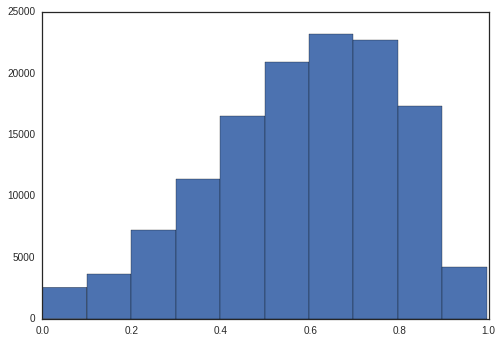

In [12]:
plt.hist(y_test)

(array([ 107732.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,  151699.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

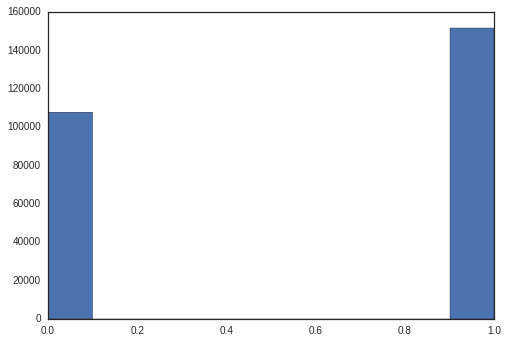

In [14]:
plt.hist(y_train)